
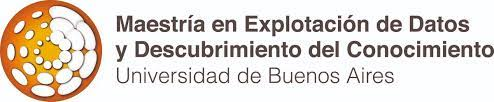

--------
# **Aprendizaje automático**
      1er cuatrimestre 2021 
      TRABAJO PRÁCTICO Nº 1

<u>**Integrantes**</u>:

* López Malizia, Álvaro
* Padula, Eliana Inés
* Rossi, Fabiana Alejandra
--------

### ***colab con variables continuas agrupadas***: *https://colab.research.google.com/drive/1LH8_gBQlhF5cHAlG48qJR8JuXfn_F44_?usp=sharing#scrollTo=D1str1Lwblqv*


### ***Objetivo:*** *Predecir qué paciente va a sufrir un accidente cerebrovascular (ACV) mediante uso de algoritmos para la generación de árboles de decisión utilizando un conjunto de datos casi reales*.

----------

# LIBRERÍAS UTILIZADAS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score,confusion_matrix, classification_report,make_scorer,roc_curve
from sklearn.tree import plot_tree,DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV, cross_validate, GridSearchCV, cross_val_predict
from sklearn.feature_selection import RFE
from sklearn.calibration import calibration_curve
from google.colab import drive


# FUNCIONES UTILIZADAS

In [2]:
def partir(dataset,feature,valor):
    datos_menor = dataset[dataset[feature] < valor]
    datos_mayor = dataset[dataset[feature] >= valor]
    return [datos_menor,datos_mayor]

def impureza_gini(grupos):
    datos_completos = pd.concat(grupos)
    N = len(datos_completos)
    gini = 0
    for grupo in grupos:
        props = grupo['stroke'].value_counts(normalize=True)
        props = props.dropna()
        gini_i = (props*(1-props)).sum()
        gini += gini_i*(len(grupo)/N)
    return gini

def buscar_mejor_particion(datos,features):
  #Partimos de un valor de Gini inicial:
    minimo_gini = 1
    for feature in features: #Recorro cada feature
        for idx, dato in datos.iterrows(): #Recorro cada dato
            valor = dato[feature] #Para cada dato veo cuanto vale en esa feature
            grupos = partir(datos,feature,valor) #Hago una particion usando esa feature con ese valor
            gini = impureza_gini(grupos) #Calculo gini de la particion (o entropia)
            if gini<minimo_gini: #Si es menor que el que antes era minimo entonces esta es mi nueva mejor particion y mi nuevo mejor gini.
                minimo_gini = gini
                mejor_particion = {'feature': feature, 'valor': valor, 'gini': minimo_gini, 'l': grupos[0], 'r': grupos[1]}
  #Una vez que probe todas las combinaciones de features y valores, devuelvo la particion que me quedo con el menor Gini
    return mejor_particion

# CARGA DE BASE DE DATOS

In [3]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/healthcare-dataset-stroke-data.csv')
df.head()


Mounted at /content/drive


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# DESCRIPCIÓN DE ATRIBUTOS

PUNTO A)
* breve explicación de qué representan 
* tipo de variable (categórica, numérica u ordinal)
* Posibles valores (y frecuencia) que toman las variables no numéricas

In [4]:
# Se evalúa el tipo de datos que tiene la dataframe
descripcion_datos=pd.DataFrame(df.dtypes)
descripcion_datos.columns=['tipo de dato']
descripcion_datos

,tipo de dato
id,int64
gender,object
age,float64
hypertension,int64
heart_disease,int64
ever_married,object
work_type,object
Residence_type,object
avg_glucose_level,float64
bmi,float64


In [5]:
# Descripción estadística de las variables numéricas
df.describe() 

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
# Evaluación de posibles datos duplicados (inconsistencia de datos en id)
df.duplicated().value_counts() 

False    5110
dtype: int64

In [7]:
# Evaluación de los posibles niveles de los atributos categóricos
print('Tipo de dato:',df['gender'].dtypes,'/ categorías de gender:',pd.unique(df['gender']))
print('Tipo de dato:',df['ever_married'].dtypes,'/ categorías de ever_married:',pd.unique(df['ever_married']))
print('Tipo de dato:',df['work_type'].dtypes,'/ categorías de work_type:',pd.unique(df['work_type']))
print('Tipo de dato:',df['Residence_type'].dtypes,'/ categorías de Residence_type:',pd.unique(df['Residence_type']))
print('Tipo de dato:',df['smoking_status'].dtypes,'/ categorías de smoking_status:',pd.unique(df['smoking_status']))

Tipo de dato: object / categorías de gender: ['Male' 'Female' 'Other']
Tipo de dato: object / categorías de ever_married: ['Yes' 'No']
Tipo de dato: object / categorías de work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Tipo de dato: object / categorías de Residence_type: ['Urban' 'Rural']
Tipo de dato: object / categorías de smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [8]:
# Frecuencia de valores en variables no numéricas
df['gender'].value_counts()
df['ever_married'].value_counts()
df['work_type'].value_counts()
df['Residence_type'].value_counts()
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [9]:
# Eliminación de atributo 'id': no es informativo
df = df.drop(['id'], axis = 1)
# Eliminación de fila para el cual el valor de 'gender' es igual a 'Other', ya que representa 1/5110 casos
df=df.drop(df.loc[df['gender']=='Other'].index)

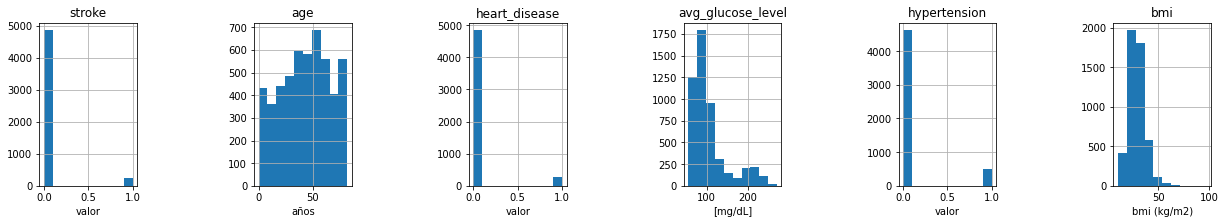

In [10]:
# Breve análisis de las variables numéricas
variables_numericas= ["stroke", "age","heart_disease","avg_glucose_level","hypertension","bmi"]
vn=df[variables_numericas]
# Histogramas
fig, axes = plt.subplots(nrows=1, ncols=6,figsize=(21,3))
plt.subplots_adjust(wspace=1.2, hspace=0.5)
vn["stroke"].hist(ax=axes[0]);
axes[0].set_title("stroke");axes[0].set_xlabel('valor');
vn["age"].hist(ax=axes[1]);
axes[1].set_title("age");axes[1].set_xlabel('años');
vn["heart_disease"].hist(ax=axes[2]);
axes[2].set_title("heart_disease");axes[2].set_xlabel('valor');
vn["avg_glucose_level"].hist(ax=axes[3]);
axes[3].set_title("avg_glucose_level");axes[3].set_xlabel('[mg/dL]');
vn["hypertension"].hist(ax=axes[4]);
axes[4].set_title("hypertension");axes[4].set_xlabel('valor');
vn["bmi"].hist(ax=axes[5]);
axes[5].set_title("bmi");axes[5].set_xlabel('bmi (kg/m2)');


EL ANÁLISIS DERIVADO DE LOS HISTOGRAMAS REVELA QUE LAS VARIABLES **STROKE**, **HEART_DISEASE** E **HYPERTENSION** no son numéricas contínuas, sino que son factores

---------------
PUNTO B)
* Cálculo de número de datos faltantes 

In [11]:
# Evaluación de atributos con valores faltantes
df.isnull().any() 

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [12]:
# Suma de la cantidad de registros con datos faltantes
print('La/s categorías que tienen nulls son: \n')
df[df.columns[df.isnull().any()]].isnull().sum() # isna podría también haberse utilizado

La/s categorías que tienen nulls son: 



bmi    201
dtype: int64

In [13]:
# Cálculo del porcentaje de datos que se perderían si se decidiese no imputar los valores nulos
print('perder 201 en 5109 sería perder:',round((201*100/5109),2),'% de los datos')

perder 201 en 5109 sería perder: 3.93 % de los datos


SE DECIDE IMPUTAR LOS VALORES FALTANTES DE LA VARIABLE **BMI** CON LA MEDIA DEL CONJUNTO DE DESARROLLO, AGRUPANDO POR SEXO
(_ver más adelante_)


--------
PUNTO C)
* Análisis de la relación de las variables con el evento de lesión (*stroke*)

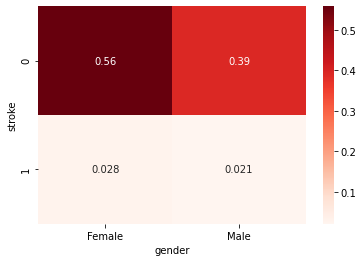

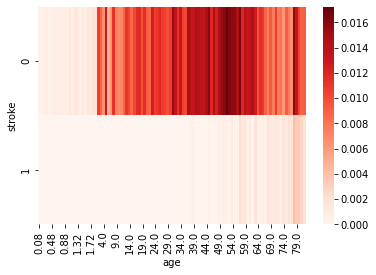

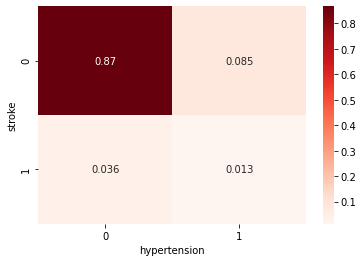

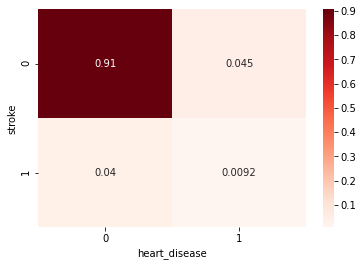

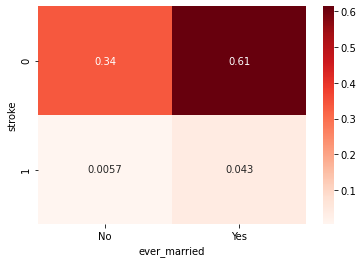

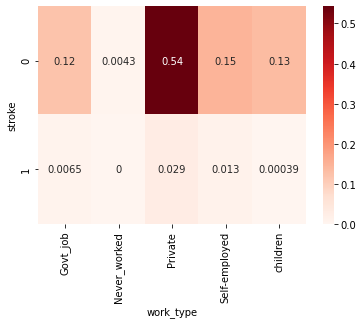

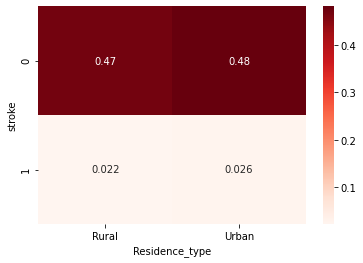

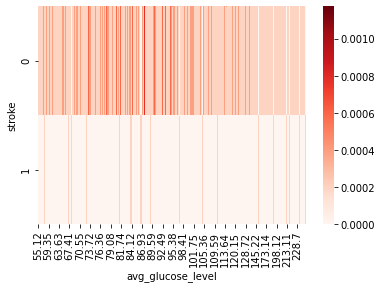

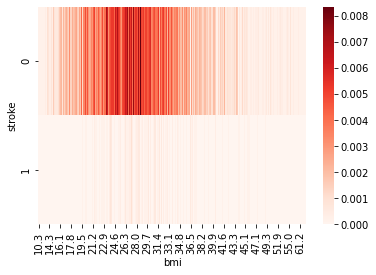

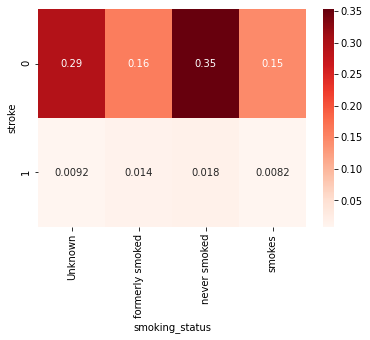

In [14]:
# Análisis gráfico mediante Heatmap 

x= "stroke"
y= ['gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi','smoking_status']
z =  [True,False,True,True,True,True,True,False,False,True]

for i in range(len(y)):#cambiar numero
    crosstab = pd.crosstab(df['stroke'],df[y[i]],margins = False, normalize = True)
    sns.heatmap(crosstab,cmap='Reds',annot=z[i])
    plt.show()


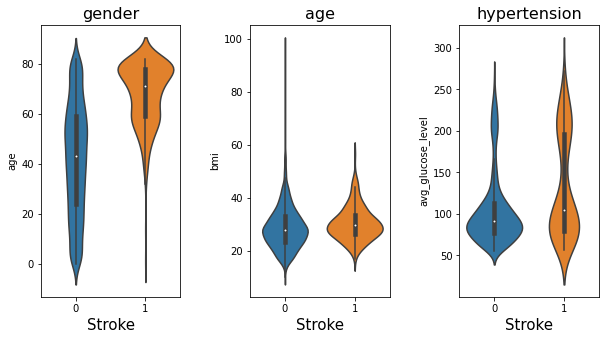

In [15]:
# Análisis gráfico mediante violinplot de las variables numéricas

figu, exs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
plt.subplots_adjust(wspace = 0.5)

x= "stroke"
y2= ["age","bmi","avg_glucose_level"]

for i in range(len(y2)):
    ex=sns.violinplot(x="stroke", y=y2[i], data=df, ax=exs[i])
    ex.set_xlabel('Stroke', size=15)
    ex.set_title(y[i], size=16)

# PROCESAMIENTO DE LA BASE DE DATOS

In [16]:
# Encoding de las variables 'work_type' y 'smoking_status' mediante dummies

dfh=copy.deepcopy(df) 
lista_categoricas=['work_type','smoking_status'] 
for i in lista_categoricas:
    xx=pd.get_dummies(df[i])
    dfh=pd.concat([dfh,xx],axis=1)

df=dfh

In [17]:
# Elimino las variables originales que fueron convertidas mediante dummies

df=df.loc[:, df.columns != 'work_type']
df=df.loc[:, df.columns != 'smoking_status']

In [18]:
# Encoding de las variables binarias con Label encoding

le = LabelEncoder()
df['ever_married']= le.fit_transform(df['ever_married'])
df['gender']= le.fit_transform(df['gender'])
df['Residence_type']= le.fit_transform(df['Residence_type'])

------
PUNTO D)
* Determinación de indicadores que determinan más susceptibilidad a sufrir una lesión


In [19]:
lista_gini=['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'Govt_job',
       'Never_worked', 'Private', 'Self-employed', 'children', 'Unknown',
       'formerly smoked', 'never smoked', 'smokes']

In [20]:
# Cálculo de information gain utilizando gini

#gini_list=[]
#for i in lista_gini: #-------------------------------------------------la comento porque tarda un montón
#  gini_list.append(buscar_mejor_particion(df,[i]).get('gini'))

In [21]:
#(pd.DataFrame(gini_list,lista_gini)).sort_values(by=0) # para que se vea, hay que descomentar lo anterior

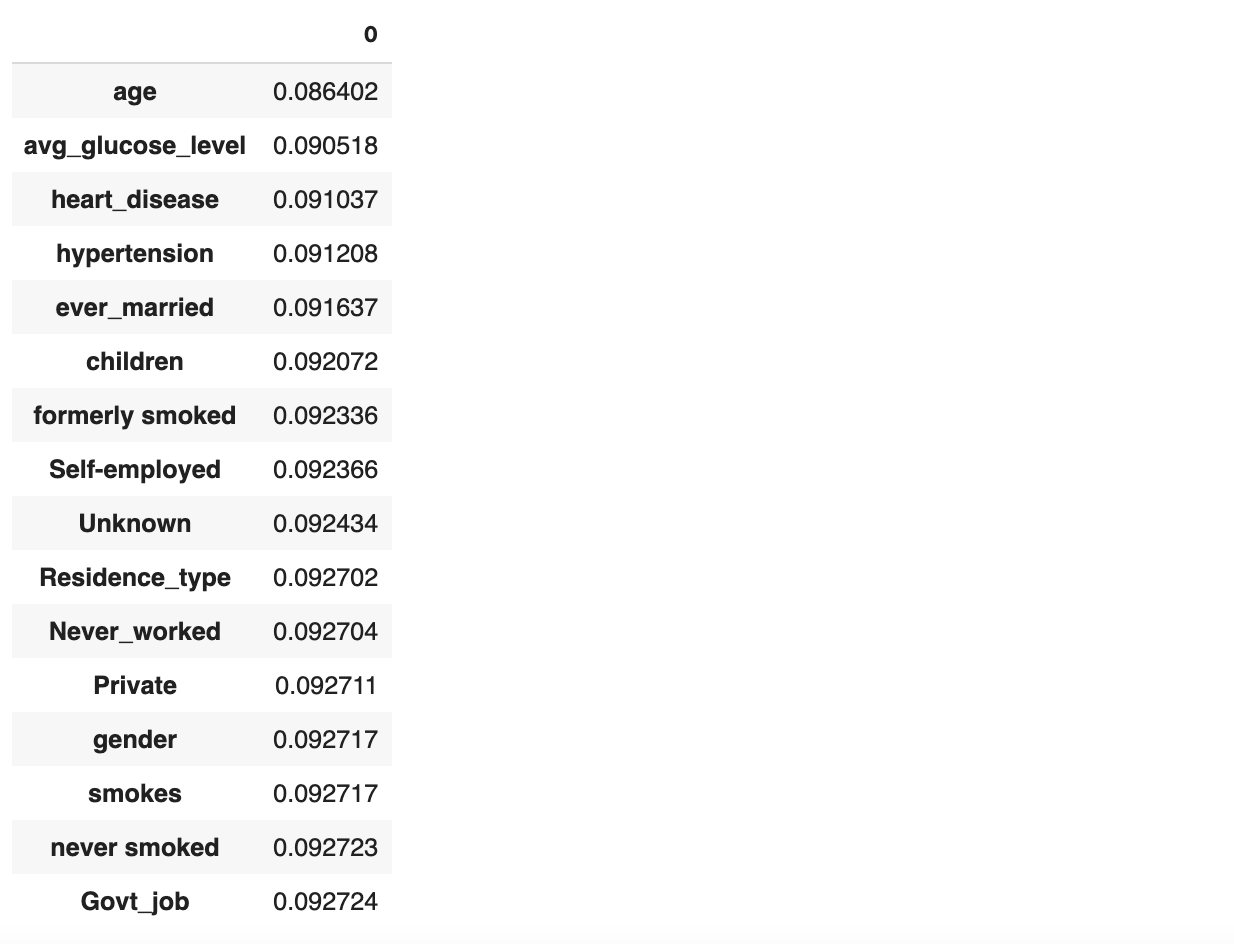


--------
PUNTOS E y F)
* Evaluación del balance del conjunto de datos
* Elección de métricas de performance 
* Estrategia de balanceo elegida
* Elección de valor de Fβ-Score suponiendo que es más importante detectar los casos en donde el evento ocurre

In [22]:
# Análisis del balance de la variable OBJETIVO (target)
df['stroke'].value_counts(normalize=True) 

0    0.951262
1    0.048738
Name: stroke, dtype: float64

<u>Elección de métricas de performance:</u> **ACCURACY** es muy sensible al desbalanceo de clases, así que no se utiliza.
Dado que el interés de nuestro análisis radica en predecir la mayor cantidad de eventos de Stroke positivos, se utilizará **RECALL** (a costas de detectar falsos positivos), o **Fβ-Score=2**

A fin de balancear los datos se utilizará el parámetro **stratify**, a fin de asegurar una distribución equitativa de la variable target positiva (minoritaria) en los subconjuntos de desarrollo y test (o *Held out*).  

Por otro lado, y se utilizará el parámetro **class_weigth='balanced'** con el objeto de asignarle mayor peso relativo a los datos  con valor de 'stroke'=1

-------
# ARBOLES DE DECISIÓN

PUNTO G)
* Implementar el algoritmo introducido en el punto d) utilizando árboles de decisión. En primer lugar, se deberá separar un 20% de los datos para usarlos como conjunto de evaluación (test set). El conjunto restante (80%) es el de desarrollo y es con el que se deberá continuar haciendo el trabajo

In [23]:
# División del Dataset en Desarrollo y HeldOut en proporcion 80% y 20%
features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'Govt_job',
       'Never_worked', 'Private', 'Self-employed', 'children', 'Unknown',
       'formerly smoked', 'never smoked', 'smokes']
x_dev, x_test, y_dev, y_test = train_test_split(df[features].values, df['stroke'].values, test_size=0.2, random_state=50,stratify=df['stroke'].values)


IMPUTACION DE VALORES FALTANTES EN BMI CON MEDIA DEL CONJUNTO DE DESARROLLO, AGRUPANDO POR SEXO

In [24]:
# Creación de nuevas df temporales que contengan datos de desarrollo y test
dev=pd.DataFrame(x_dev)
dev_y=pd.DataFrame(y_dev)
dev.columns=features

ttest=pd.DataFrame(x_test)
ttest.columns=features
ttest_y=pd.DataFrame(y_test)

In [25]:
# Cálculo de las medias según sexo en conjunto de desarrollo
medias=dev.groupby(['gender'])['bmi'].mean()
medias

gender
0.0    29.032694
1.0    28.593203
Name: bmi, dtype: float64

In [26]:
# Reemplazo de valores bmi nulos por la media, según el sexo en cada una de las df (dev y test)
dev.loc[dev['gender'].eq(0) & dev['bmi'].isnull(), 'bmi'] = medias[0]
dev.loc[dev['gender'].eq(1) & dev['bmi'].isnull(), 'bmi'] = medias[1]

ttest.loc[ttest['gender'].eq(0) & ttest['bmi'].isnull(), 'bmi'] = medias[0]
ttest.loc[ttest['gender'].eq(1) & ttest['bmi'].isnull(), 'bmi'] = medias[1]

#ttest.isnull().any() 
#dev.isnull().any()

In [27]:
# paso dev y ttest df temporales nuevamente a numpy array
x_dev=dev.to_numpy()
x_test=ttest.to_numpy()

NÚMERO DE MUESTRAS EN EL CONJUNTO DE ENTRENAMIENTO (desarrollo) Y HELDOUT (test)



In [28]:
print('Desarollo: {}'.format(len(x_dev))) 
print('Prueba: {}'.format(len(x_test))) 

Desarollo: 4087
Prueba: 1022


In [29]:
# FRECUENCIA DE VALORES '0' PARA STROKE EN CADA UNO DE LOS CONJUNTOS DE ENTRENAMIENTO Y HELDOUT
for split_name, split in zip(['Desarollo','Prueba'],[y_dev,y_test]):
    print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[0]))

Desarollo: 0.951
Prueba: 0.951


In [30]:
# FRECUENCIA DE VALORES '1' PARA STROKE EN CADA UNO DE LOS CONJUNTOS DE ENTRENAMIENTO Y HELDOUT
for split_name, split in zip(['Desarrollo','Prueba'],[y_dev,y_test]):
    print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]))

Desarrollo: 0.049
Prueba: 0.049


-------------------
### ARBOL 1 
* Uso de 50 semillas distintas 
* Gráfico de caja y bigotes que muestre cómo varía la métrica elegida en c)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


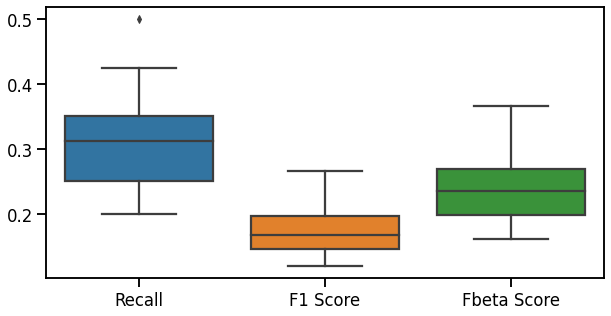

In [31]:
# Aca se realizan 50 particiones distintas del set de Desarrollo 
# En distintas iteraciones se cambia el seed que genera el Conjunto de Entrenamiento y Validacion a traves de train_test_split

n_seeds = 50 
seed_n = [] 
# Se arma una lista vacía para cada métrica, y una para los árboles
recalls = [] 
f1s = [] 
fbeta=[] 
arbol = []

for seed in range(n_seeds): 
    x_train, x_val, y_train, y_val = train_test_split(x_dev, y_dev, test_size=0.2, random_state=seed,stratify=y_dev)
    seed_n.append(seed)

    arbol_sklearn = DecisionTreeClassifier(criterion='gini',max_depth=15,min_samples_leaf=5, ccp_alpha=0, class_weight='balanced')
    arbol_sklearn.fit(x_train,y_train) 

    y_pred_val = arbol_sklearn.predict(x_val) 
    f1s.append(f1_score(y_val, y_pred_val))
    recalls.append(recall_score(y_val,y_pred_val))
    fbeta.append(fbeta_score(y_val, y_pred_val, 2))
    arbol.append(arbol_sklearn)

all_metrics = recalls + f1s + fbeta 
metric_labels = ['Recall']*len(recalls) + ['F1 Score']*len(f1s) + ['Fbeta Score']*len(fbeta)

sns.set_context('talk')
plt.figure(figsize=(10,5))
sns.boxplot(metric_labels,all_metrics) 

In [32]:
# Determinación del índice para el cuál la métrica de recall y fbeta es el máximo
print('max recalls',max(recalls))
print('max fbeta',max(fbeta)) 
print('indice max recalls', recalls.index(max(recalls)))
print('indice max fbeta2', fbeta.index(max(fbeta)))

max recalls 0.5
max fbeta 0.36630036630036633
indice max recalls 13
indice max fbeta2 13


[Text(558.0, 475.65000000000003, 'age <= 53.5\ngini = 0.5\nsamples = 3269\nvalue = [1634.5, 1634.5]'),
 Text(279.0, 339.75, 'age <= 37.5\ngini = 0.286\nsamples = 2077\nvalue = [1080.031, 226.157]'),
 Text(139.5, 203.85000000000002, 'avg_glucose_level <= 76.195\ngini = 0.083\nsamples = 1296\nvalue = [679.553, 30.84]'),
 Text(69.75, 67.94999999999999, '\n  (...)  \n'),
 Text(209.25, 67.94999999999999, '\n  (...)  \n'),
 Text(418.5, 203.85000000000002, 'age <= 39.5\ngini = 0.441\nsamples = 781\nvalue = [400.479, 195.318]'),
 Text(348.75, 67.94999999999999, '\n  (...)  \n'),
 Text(488.25, 67.94999999999999, '\n  (...)  \n'),
 Text(837.0, 339.75, 'age <= 67.5\ngini = 0.405\nsamples = 1192\nvalue = [554.469, 1408.343]'),
 Text(697.5, 203.85000000000002, 'avg_glucose_level <= 67.215\ngini = 0.483\nsamples = 652\nvalue = [319.017, 462.594]'),
 Text(627.75, 67.94999999999999, '\n  (...)  \n'),
 Text(767.25, 67.94999999999999, '\n  (...)  \n'),
 Text(976.5, 203.85000000000002, 'avg_glucose_level

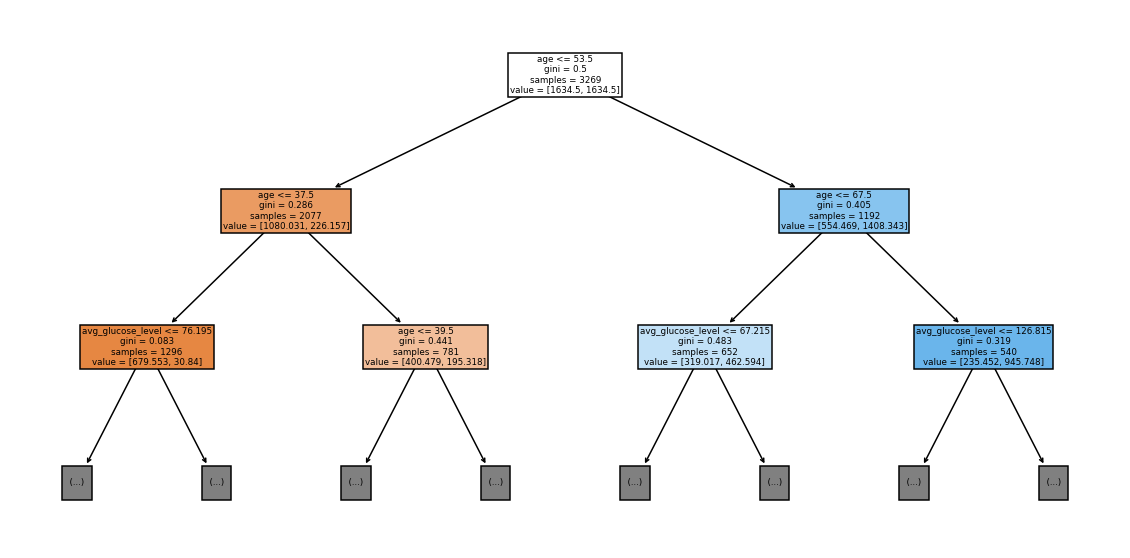

In [33]:
# Mejor árbol según la métrica de recall y fbeta2
plt.figure(figsize=(20,10))
plot_tree(arbol[13], feature_names = dev.columns,filled=True,max_depth= 2) 

mejor semilla

### ARBOL 2 
* Uso de validación cruzada de 50 iteraciones (50-fold cross validation)s 
* Gráfico de caja y bigotes que muestre cómo varía la métrica elegida en c)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


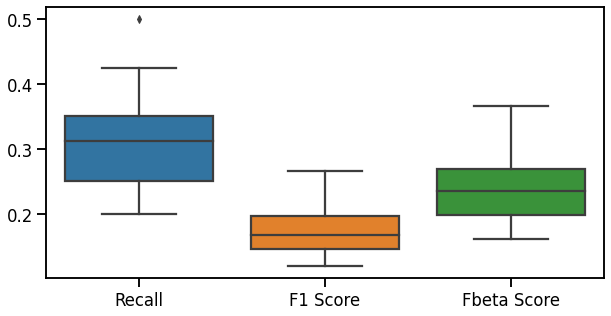

In [34]:
# Lista para cada métrica, y para los árboles
f1_50=[]
recalls_50 = [] 
fbeta_50=[] 
arbol_guardado_50=[]

skf=StratifiedKFold(n_splits=50, random_state=None, shuffle=False)

for train_index, test_index in skf.split(x_dev, y_dev):  # vamos a recorrer los indices de los distintos folds
    x_train, x_val = x_dev[train_index], x_dev[test_index] # aca defino el x_train y x_val para el indice train_index y test_index
    y_train, y_val = y_dev[train_index], y_dev[test_index] # aca defino el y_train y y_val para el indice train_index y test_index

    arbol_sklearn = DecisionTreeClassifier(criterion='gini',max_depth=15,min_samples_leaf=5, ccp_alpha=0, random_state=15, class_weight='balanced')
    arbol_sklearn.fit(x_train,y_train) # aca lo entreno

    y_pred_val = arbol_sklearn.predict(x_val) 
    f1_50.append(f1_score(y_val, y_pred_val))
    recalls_50.append(recall_score(y_val,y_pred_val))
    fbeta_50.append(fbeta_score(y_val, y_pred_val, 2))
 
    arbol_guardado_50.append(arbol_sklearn)

all_metrics = recalls + f1s + fbeta 
metric_labels = ['Recall']*len(recalls) + ['F1 Score']*len(f1s) + ['Fbeta Score']*len(fbeta)

sns.set_context('talk')
plt.figure(figsize=(10,5))
sns.boxplot(metric_labels,all_metrics) 

In [35]:
#Para poder encontrar el arbol de mejor performance, buscamos el kfold cuyas medidas de performance sean máximas.
print('max recalls',max(recalls_50))
print('max fbeta',max(fbeta_50)) 
print('max f1',max(f1_50)) 
print('indice max recalls', recalls_50.index(max(recalls_50)))
print('indice max fbeta', fbeta_50.index(max(fbeta_50)))
print('indice max f1', f1_50.index(max(f1_50)))
print('promedio',((recalls_50[recalls_50.index(max(recalls_50))]+fbeta_50[fbeta_50.index(max(fbeta_50))])+f1_50[f1_50.index(max(f1_50))])/3)

max recalls 0.75
max fbeta 0.6521739130434783
max f1 0.5454545454545454
indice max recalls 19
indice max fbeta 19
indice max f1 19
promedio 0.6492094861660079


-----
PUNTO H)
* Árbol de decisión con mejor performance encontrado en el punto g2)
* Análisis del árbol de decisión armado (atributos elegidos y decisiones evaluadas)


[Text(558.0, 475.65000000000003, 'age <= 53.5\ngini = 0.5\nsamples = 4005\nvalue = [2002.5, 2002.5]'),
 Text(279.0, 339.75, 'age <= 37.5\ngini = 0.265\nsamples = 2542\nvalue = [1323.437, 246.462]'),
 Text(139.5, 203.85000000000002, 'avg_glucose_level <= 76.16\ngini = 0.07\nsamples = 1569\nvalue = [823.075, 30.808]'),
 Text(69.75, 67.94999999999999, '\n  (...)  \n'),
 Text(209.25, 67.94999999999999, '\n  (...)  \n'),
 Text(418.5, 203.85000000000002, 'hypertension <= 0.5\ngini = 0.421\nsamples = 973\nvalue = [500.362, 215.654]'),
 Text(348.75, 67.94999999999999, '\n  (...)  \n'),
 Text(488.25, 67.94999999999999, '\n  (...)  \n'),
 Text(837.0, 339.75, 'age <= 67.5\ngini = 0.402\nsamples = 1463\nvalue = [679.063, 1756.038]'),
 Text(697.5, 203.85000000000002, 'avg_glucose_level <= 104.465\ngini = 0.483\nsamples = 793\nvalue = [387.886, 564.808]'),
 Text(627.75, 67.94999999999999, '\n  (...)  \n'),
 Text(767.25, 67.94999999999999, '\n  (...)  \n'),
 Text(976.5, 203.85000000000002, 'avg_gluco

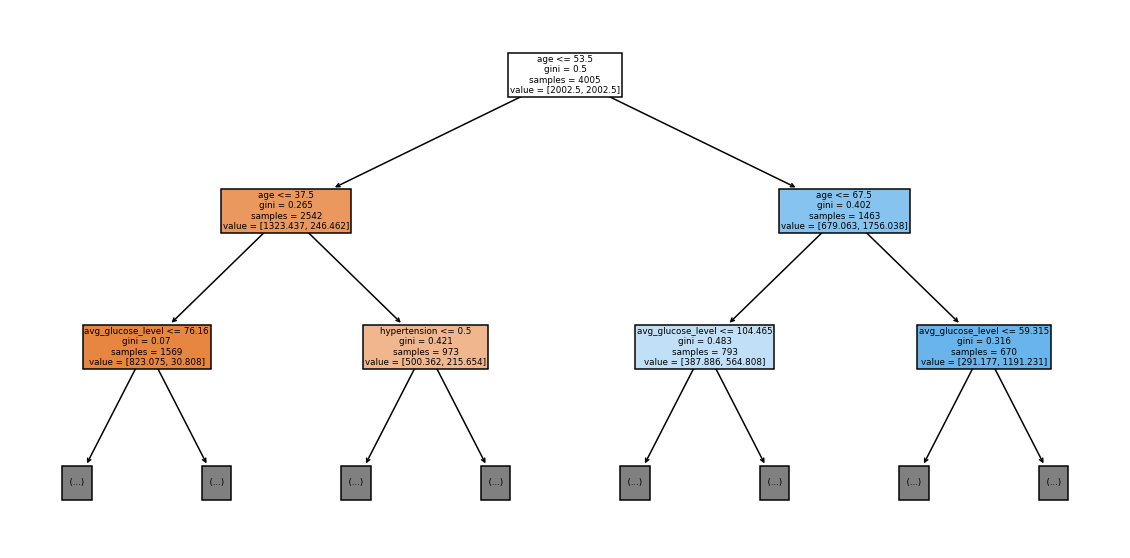

In [36]:
# Graficamos el mejor árbol según la métrica recall y Fbeta2
plt.figure(figsize=(20,10))
plot_tree(arbol_guardado_50[19], filled=True,feature_names = dev.columns,max_depth= 2)

In [37]:
# Importancia de los atributos que utilizo para constuir el arbol
arbol_elegido=arbol_guardado_50[19]
feat_imps_elegido=arbol_elegido.feature_importances_ 
feat_imps_elegido

array([0.02393634, 0.49310546, 0.01710322, 0.01055889, 0.00283957,
       0.01709014, 0.21311932, 0.17325238, 0.00354801, 0.        ,
       0.00449709, 0.00254788, 0.        , 0.00163407, 0.01690706,
       0.01403674, 0.00582384])

In [38]:
# Nombres de las variables más importantes
for feat_imps,feat in sorted(zip(feat_imps_elegido,features), reverse=True):
    if feat_imps>0:
        print('{}: {}'.format(feat,round(feat_imps,3)))

age: 0.493
avg_glucose_level: 0.213
bmi: 0.173
gender: 0.024
hypertension: 0.017
Residence_type: 0.017
formerly smoked: 0.017
never smoked: 0.014
heart_disease: 0.011
smokes: 0.006
Private: 0.004
Govt_job: 0.004
ever_married: 0.003
Self-employed: 0.003
Unknown: 0.002


PUNTO I)
* Probar distintos valores de α del algoritmo de poda mínima de complejidad de costos (algoritmo de poda de sklearn usando validación cruzada de 10 iteraciones (10-fold cross validation).
* Gráficos de la performance en validación y entrenamiento en función del α.
* Gráficos de la profundidad de los árboles al realizar la poda con distintos valores de α. 

### PASO 1: Se generan los alfas según el algoritmo de poda de minima complejidad

El número de nodos en el último arbol es: 1 with ccp_alpha: 0.14219137199433468


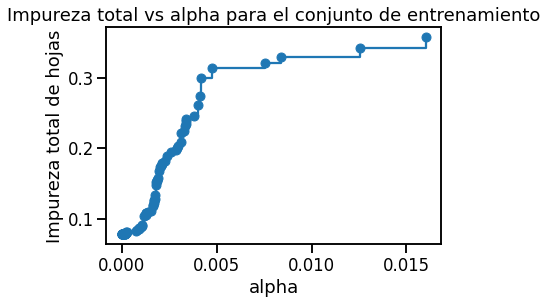

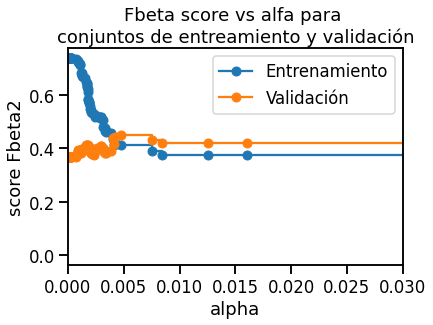

In [39]:
#Separación de los datos nuevamente, para no utilizar los datos split de 50kfold de la última corrida 
x_train, x_val, y_train, y_val = train_test_split(x_dev, y_dev, test_size=0.2, random_state=13,stratify=y_dev) 
clf = DecisionTreeClassifier(criterion='gini',random_state=15, class_weight = 'balanced',max_depth=15,min_samples_leaf=5)
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("alpha")
ax.set_ylabel("Impureza total de hojas")
ax.set_title("Impureza total vs alpha para el conjunto de entrenamiento")
alfa = []
clfs = []
train_scores =  []
val_scores = []

# Se corren árboles para cada ccp_alpha del algoritmo y calculan scores
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini',ccp_alpha=ccp_alpha, random_state=15, class_weight = 'balanced',max_depth=15,min_samples_leaf=5) #poniendo todo de alguna manera ya topeo el pruning
    clf.fit(x_train, y_train)
    clfs.append(clf)
    alfa.append(ccp_alpha)
    y_pred_train = clf.predict(x_train)
    y_pred_val = clf.predict(x_val) 
    train_scores.append(fbeta_score(y_train, y_pred_train, 2)) 
    val_scores.append(fbeta_score(y_val, y_pred_val, 2))
print("El número de nodos en el último arbol es: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

# Se grafican 
# 1) Impureza vs alpha para training set
# 2) F beta score vs alpha para training y validation set
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("score Fbeta2")
ax.set_title("Fbeta score vs alfa para \nconjuntos de entreamiento y validación")
ax.plot(ccp_alphas, train_scores, marker='o', label="Entrenamiento", 
        drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker='o', label="Validación",
        drawstyle="steps-post")
ax.legend()
plt.ylim()
plt.xlim(0,0.03)
plt.show()


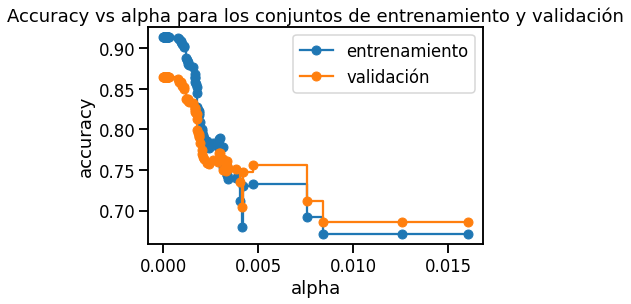

In [40]:
# Gráfico de Accuracy vs alpha para conjuntos de entrenamiento y validación
train_scores = [clf.score(x_train, y_train) for clf in clfs] 
val_scores = [clf.score(x_val, y_val) for clf in clfs] 

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha para los conjuntos de entrenamiento y validación")
ax.plot(ccp_alphas[:-1], train_scores[:-1], marker='o', label="entrenamiento", 
        drawstyle="steps-post")
ax.plot(ccp_alphas[:-1], val_scores[:-1], marker='o', label="validación",
        drawstyle="steps-post")
ax.legend()
plt.xlim()
plt.show()
#

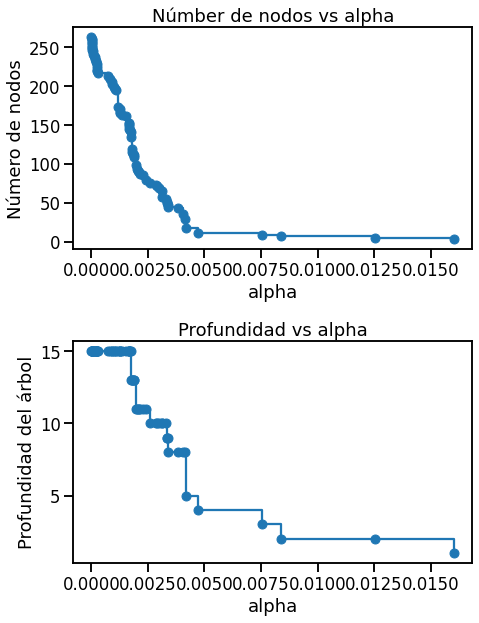

In [41]:
# Gráfico del número de nodos vs alpha
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = (plt.subplots(2, 1,figsize=(7,9)))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("Número de nodos")
ax[0].set_title("Númber de nodos vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("Profundidad del árbol")
ax[1].set_title("Profundidad vs alpha")
fig.tight_layout()

### PASO 2 : con los alphas generados, se realiza 10KFOLD. Se usa GRID SEARCH para que la búsqueda sea por todos los alphas

In [42]:
alfa_array = np.array(alfa[:-1]) 
params_grid = {'criterion':['gini'],
               'max_depth': [15],
               'min_samples_leaf': [5],
                'class_weight': ['balanced'],
               'ccp_alpha': alfa_array} 
kfoldcv = StratifiedKFold(n_splits=10) 
base_tree = DecisionTreeClassifier(random_state=15) 
scorer_fbeta=make_scorer(fbeta_score, beta=2)

## GRID SEARCH ##
# DEFINICIÓN DE MEJOR ARBOL
gridcv = GridSearchCV(estimator=base_tree, param_grid= params_grid,  scoring=scorer_fbeta,cv=kfoldcv, verbose =10)
gridcv.fit(x_dev,y_dev)
Best_tree =  gridcv.best_estimator_
resultados_grid = pd.DataFrame(gridcv.cv_results_, columns = ['mean_test_score','std_test_score','param_ccp_alpha'])


Fitting 10 folds for each of 73 candidates, totalling 730 fits
[CV] ccp_alpha=0.0, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5 
[CV]  ccp_alpha=0.0, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5, score=0.154, total=   0.0s
[CV] ccp_alpha=0.0, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5 
[CV]  ccp_alpha=0.0, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5, score=0.159, total=   0.0s
[CV] ccp_alpha=0.0, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5 
[CV]  ccp_alpha=0.0, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5, score=0.165, total=   0.0s
[CV] ccp_alpha=0.0, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5 
[CV]  ccp_alpha=0.0, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5, score=0.273, total=   0.0s
[CV] ccp_alpha=0.0, class_weight=balanced, criterion=gini, max_depth=15, min_samp

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV]  ccp_alpha=1.1705635683597433e-05, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5, score=0.159, total=   0.0s
[CV] ccp_alpha=1.1705635683597433e-05, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5 
[CV]  ccp_alpha=1.1705635683597433e-05, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5, score=0.165, total=   0.0s
[CV] ccp_alpha=1.1705635683597433e-05, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5 
[CV]  ccp_alpha=1.1705635683597433e-05, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5, score=0.273, total=   0.0s
[CV] ccp_alpha=1.1705635683597433e-05, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5 
[CV]  ccp_alpha=1.1705635683597433e-05, class_weight=balanced, criterion=gini, max_depth=15, min_samples_leaf=5, score=0.203, total=   0.0s
[CV] ccp_alpha=1.1705635683597433e-05, class_weight=balanced, criterion=gini, max_depth=15, min_samples_

[Parallel(n_jobs=1)]: Done 730 out of 730 | elapsed:   10.2s finished


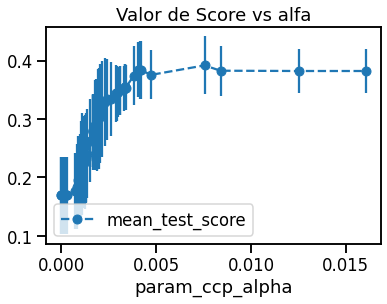

In [43]:
# Resultado de realizar 10kfolds para cada uno de los ccp_alpha arrojados por el algoritmo
resultados_grid.plot(x = 'param_ccp_alpha', y = 'mean_test_score', yerr = 'std_test_score', marker = 'o', linestyle = '--', title='Valor de Score vs alfa')

In [44]:
# Mejores parámetros
gridcv.best_params_

{'ccp_alpha': 0.007552959810980392,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 5}

### ARBOL 3


[Text(279.0, 226.5, 'age <= 53.5\ngini = 0.5\nsamples = 100.0%\nvalue = [0.5, 0.5]'),
 Text(139.5, 135.9, 'age <= 37.5\ngini = 0.26\nsamples = 63.7%\nvalue = [0.846, 0.154]'),
 Text(69.75, 45.29999999999998, 'gini = 0.068\nsamples = 39.5%\nvalue = [0.965, 0.035]'),
 Text(209.25, 45.29999999999998, 'gini = 0.418\nsamples = 24.1%\nvalue = [0.702, 0.298]'),
 Text(418.5, 135.9, 'age <= 67.5\ngini = 0.401\nsamples = 36.3%\nvalue = [0.277, 0.723]'),
 Text(348.75, 45.29999999999998, 'gini = 0.481\nsamples = 19.7%\nvalue = [0.402, 0.598]'),
 Text(488.25, 45.29999999999998, 'gini = 0.315\nsamples = 16.6%\nvalue = [0.196, 0.804]')]

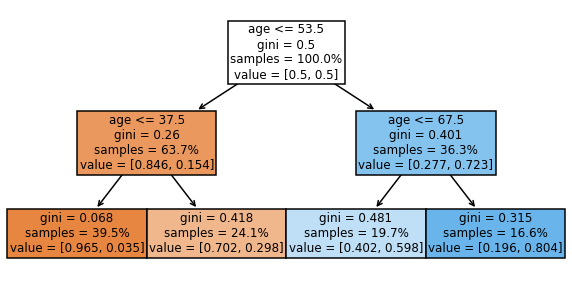

In [45]:
# Gráfico del mejor árbol
plt.figure(figsize=(10,5))
plot_tree(Best_tree, filled=True, feature_names = dev.columns, proportion = True)

-------
PUNTO J)
* Evaluar en el conjunto de evaluación (test), el árbol correspondiente al α que maximice la performance en el conjunto de validación. 
* Comparar con el caso sin poda (α=0)

In [46]:
# Comparación del estadístico de la evaluación del conjunto test con un arbol de alpha 0 y el árbol "Best tree"
arbol_alpha0 = DecisionTreeClassifier(criterion='gini',max_depth=15,min_samples_leaf = 5, ccp_alpha=0, class_weight='balanced')
arbol_alpha0.fit(x_dev,y_dev) 
y_pred_test0 = arbol_alpha0.predict(x_test)

arbol_alpha4 = Best_tree
arbol_alpha4.fit(x_dev,y_dev) 
y_pred_test4 = arbol_alpha4.predict(x_test)

print('Test F-beta = 2 con alpha 0: {}'.format(round(fbeta_score(y_test,y_pred_test0, beta =2),2)))
print('Test F-beta = 2 con alpha max performance: {}'.format(round(fbeta_score(y_test,y_pred_test4, beta = 2),2)))


Test F-beta = 2 con alpha 0: 0.35
Test F-beta = 2 con alpha max performance: 0.37


In [47]:
# Reporte de clasificación completo
best_model = Best_tree
y_pred = best_model.predict(x_test)
alpha0_model = DecisionTreeClassifier(criterion='gini',max_depth=15,min_samples_leaf = 5, ccp_alpha=0, class_weight='balanced')
y_pred_0 = arbol_alpha0.predict(x_test)

print("Mejor Árbol")
print(classification_report(y_test,y_pred, target_names = ['No Stroke','Stroke'], digits=3))
print("Árbol con alpha = 0")
print(classification_report(y_test,y_pred_0,target_names =['No Stroke','Stroke'],digits=3))

Mejor Árbol
              precision    recall  f1-score   support

   No Stroke      0.989     0.652     0.786       972
      Stroke      0.113     0.860     0.200        50

    accuracy                          0.662      1022
   macro avg      0.551     0.756     0.493      1022
weighted avg      0.946     0.662     0.757      1022

Árbol con alpha = 0
              precision    recall  f1-score   support

   No Stroke      0.971     0.867     0.916       972
      Stroke      0.162     0.500     0.245        50

    accuracy                          0.849      1022
   macro avg      0.567     0.684     0.581      1022
weighted avg      0.932     0.849     0.883      1022



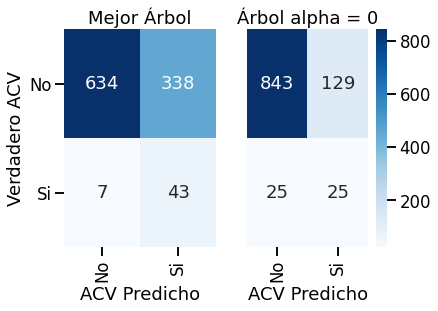

In [48]:
# Matriz de confusión

f,(ax1,ax2) = plt.subplots(1,2)

ax1.get_shared_y_axes().join(ax2)
cm_1 = confusion_matrix(y_test,y_pred)
g1 = sns.heatmap(cm_1, cmap='Blues',annot=True,fmt='g', ax = ax1, cbar = False, xticklabels= ['No','Si'], yticklabels=['No','Si'])
g1.set_xlabel('ACV Predicho')
g1.set_ylabel('Verdadero ACV')
g1.set_title('Mejor Árbol')

cm_2 = confusion_matrix(y_test,y_pred_0)
g2 = sns.heatmap(cm_2, cmap='Blues',annot=True,fmt='g', ax = ax2,yticklabels= False, xticklabels= ['No','Si'])
g2.set_xlabel('ACV Predicho')
g2.set_title('Árbol alpha = 0')

for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
    tlt = ax.get_title()
    ax.set_title(tlt, rotation=0)

plt.show()

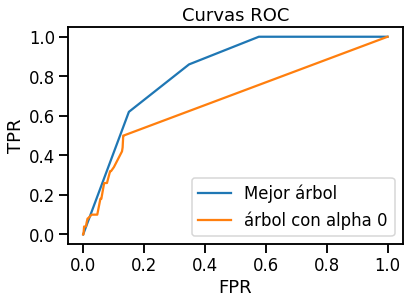

In [49]:
# Curva ROC

y_scores_0 = arbol_alpha0.predict_proba(x_test)
out_probs_0 = y_scores_0[:,1]
fpr_0,tpr_0,th_0 = roc_curve(y_test,out_probs_0)

y_scores = best_model.predict_proba(x_test)
out_probs = y_scores[:,1]
fpr,tpr,th = roc_curve(y_test,out_probs)

fig, ax = plt.subplots()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("Curvas ROC")
ax.plot(fpr,tpr,label="Mejor árbol")
ax.plot(fpr_0,tpr_0,label="árbol con alpha 0")
ax.legend()
plt.show()

-------
PUNTO J)
* Evaluación de la importancia de los descriptores usando la técnica de eliminación recursiva
* Reentrenamiento del árbol usando sólo los 3 descriptores más importantes. 
* Comparación de la performance en el conjunto de prueba.

In [50]:
# Se determinan cuáles son las X y el target
desarrollo=pd.concat([dev,dev_y],axis=1)
desarrollo.rename(columns = {0: 'stroke'},inplace = True)
X = desarrollo[features]
target = desarrollo['stroke']

In [51]:
desarrollo.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,Govt_job,Never_worked,Private,Self-employed,children,Unknown,formerly smoked,never smoked,smokes,stroke
0,0.0,14.0,0.0,0.0,0.0,1.0,124.39,34.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
1,1.0,21.0,0.0,0.0,0.0,1.0,73.81,19.8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.0,14.0,0.0,0.0,0.0,0.0,70.54,24.4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,0.0,41.0,0.0,0.0,1.0,1.0,103.79,28.6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,1.0,24.0,0.0,0.0,0.0,0.0,93.76,24.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [52]:
# Se aplica RFE
dtc = copy.deepcopy(arbol_alpha0)
rfe = RFE(estimator=dtc, step=1)
rfe.fit(X, target)
print('Optimal number of features: {}'.format(rfe.n_features_))

Optimal number of features: 8


In [53]:
# Se calculan rankings de las variables
print(rfe.ranking_)
print(features)
ranking = pd.DataFrame(features,rfe.ranking_)
ranking.reset_index(level = 0, inplace = True)
ranking.columns = ['ranking','features']

[ 1  1  1  4  3  7  1  1  9  8  6  1 10  2  1  1  5]
['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children', 'Unknown', 'formerly smoked', 'never smoked', 'smokes']


In [54]:
# Se calculan importancias de cada una
ranking.sort_values(by = 'ranking')
rfe.estimator_.feature_importances_ 

array([0.01523797, 0.51194203, 0.01279188, 0.22550434, 0.19619116,
       0.00864121, 0.01014159, 0.01954981])

In [55]:
# Se toman aquellas variables con mejor ranking
ranking.loc[ranking['ranking']==1].features

0                gender
1                   age
2          hypertension
6     avg_glucose_level
7                   bmi
11        Self-employed
14      formerly smoked
15         never smoked
Name: features, dtype: object

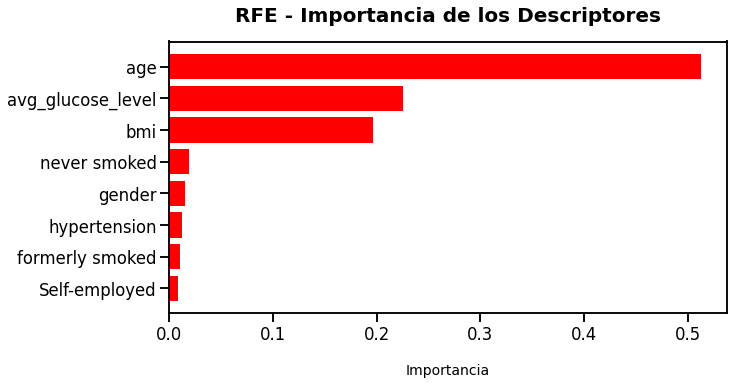

In [56]:
# Se analizan gráficamente las importancias de los features
dset = pd.DataFrame() 
dset['atributo'] =  ranking.loc[ranking['ranking']==1].features  
dset['importancia'] = rfe.estimator_.feature_importances_ 
dset = dset.sort_values(by='importancia', ascending=True) 

plt.figure(figsize=(10, 5))
plt.barh(y=dset['atributo'], width=dset['importancia'], color='red')
plt.title('RFE - Importancia de los Descriptores', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importancia', fontsize=14, labelpad=20)
plt.show() 

In [57]:
# Se toman de x_dev (vector de numpy), los 3 índices de mayor importancia

dev.columns # en este df estaba guardada la info del array... la uso para averiguar indices
x_dev[:,[1,6,7]]

array([[ 14.  , 124.39,  34.  ],
       [ 21.  ,  73.81,  19.8 ],
       [ 14.  ,  70.54,  24.4 ],
       ...,
       [ 24.  ,  85.07,  22.5 ],
       [  0.64,  60.4 ,  17.3 ],
       [ 53.  , 109.09,  26.3 ]])

In [58]:
#copia
x_dev3 = x_dev[:,[1,6,7]]
x_test3 = x_test[:,[1,6,7]]
y_dev3 = copy.deepcopy(y_dev)
y_test3 = copy.deepcopy(y_test)

In [59]:
# Entreno árbol sólo con los 3 valores de mayor importancia con 10K folds
params_grid = {'criterion':['gini'],
               'max_depth': np.asarray(range(1,51)),#[15],
               'min_samples_leaf': [5],
                'class_weight': ['balanced'],
               'ccp_alpha': [0]} 

kfoldcv = StratifiedKFold(n_splits=10) 
base_tree = DecisionTreeClassifier() 
scorer_fbeta=make_scorer(fbeta_score, beta=2)
random_3variables = RandomizedSearchCV(estimator=base_tree,param_distributions = params_grid,scoring=scorer_fbeta,cv=kfoldcv,n_iter=100)
random_3variables.fit(x_dev3,y_dev3)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0....
                                        'class_weight': ['balanced'],
    

In [60]:
# Se toma árboles de mejores parámetros

random_3variables.best_score_
random_3variables.best_params_

{'ccp_alpha': 0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 5}

[Text(558.0, 475.65000000000003, 'age <= 53.5\ngini = 0.5\nsamples = 4087\nvalue = [2043.5, 2043.5]'),
 Text(279.0, 339.75, 'age <= 37.5\ngini = 0.26\nsamples = 2602\nvalue = [1354.975, 246.452]'),
 Text(139.5, 203.85000000000002, 'avg_glucose_level <= 76.16\ngini = 0.068\nsamples = 1615\nvalue = [847.254, 30.807]'),
 Text(69.75, 67.94999999999999, 'gini = 0.219\nsamples = 412\nvalue = [214.967, 30.807]'),
 Text(209.25, 67.94999999999999, 'gini = -0.0\nsamples = 1203\nvalue = [632.287, 0.0]'),
 Text(418.5, 203.85000000000002, 'bmi <= 30.95\ngini = 0.418\nsamples = 987\nvalue = [507.721, 215.646]'),
 Text(348.75, 67.94999999999999, 'gini = 0.464\nsamples = 556\nvalue = [283.819, 164.302]'),
 Text(488.25, 67.94999999999999, 'gini = 0.303\nsamples = 431\nvalue = [223.902, 51.344]'),
 Text(837.0, 339.75, 'age <= 67.5\ngini = 0.401\nsamples = 1485\nvalue = [688.525, 1797.048]'),
 Text(697.5, 203.85000000000002, 'avg_glucose_level <= 104.465\ngini = 0.481\nsamples = 806\nvalue = [393.668, 58

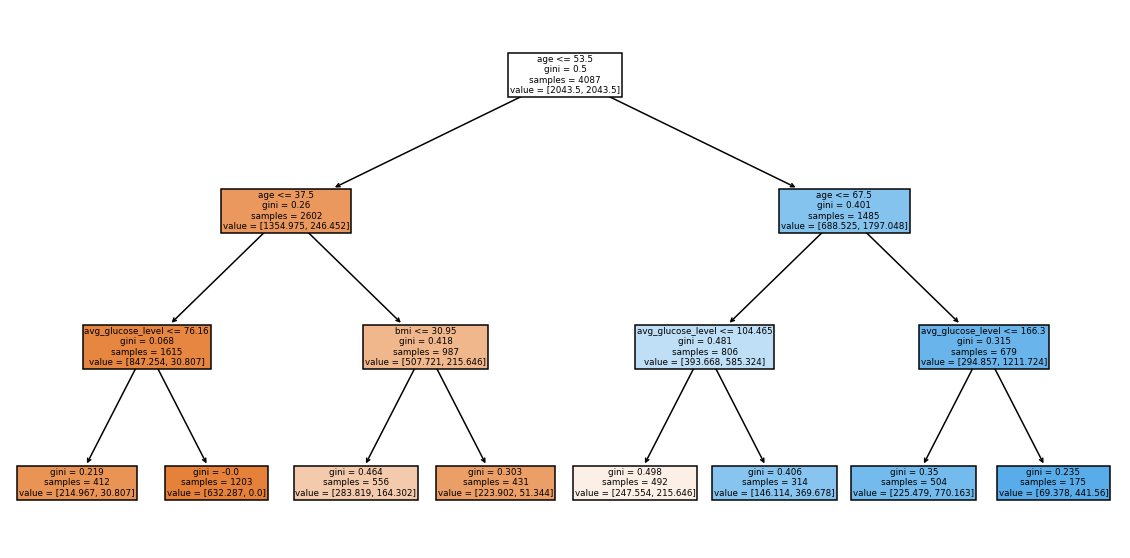

In [61]:
# Se grafica el mejor arbol construído con 3 variables
nombre_de_feat=dev.columns[[1,6,7]]
plt.figure(figsize=(20,10))
plot_tree(random_3variables.best_estimator_, feature_names =nombre_de_feat, filled=True)

In [62]:
# Se evalúa el mejor árbol entrenado con 3 variables en el conjunto de test

y_pred_test3 = random_3variables.best_estimator_.predict(x_test3) 
fbeta_best3=(fbeta_score(y_test3,y_pred_test3, beta = 2))

print('Test F-beta = 2 con alpha 0: {}'.format(round(fbeta_score(y_test,y_pred_test0, beta =2),4)))
print('Test F-beta = 2 con alpha máxima performance: {}'.format(round(fbeta_score(y_test,y_pred_test4, beta = 2),4)))
print('Test F-beta = 2 con alpha 0 menor cantidad de atributos: {}'.format(round(fbeta_best3,4)))


Test F-beta = 2 con alpha 0: 0.3531
Test F-beta = 2 con alpha máxima performance: 0.3701
Test F-beta = 2 con alpha 0 menor cantidad de atributos: 0.4111
